In [1]:
from diffusers import DiffusionPipeline
import torch

c:\Users\Steven\Desktop\gen-pixel\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipeline.to("cuda")
pipeline("An image of a squirrel in Picasso style").images[0]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\Steven\Desktop\gen-pixel\.venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Steven\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-v1-5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fetching 15 files:   7%|▋  

: 

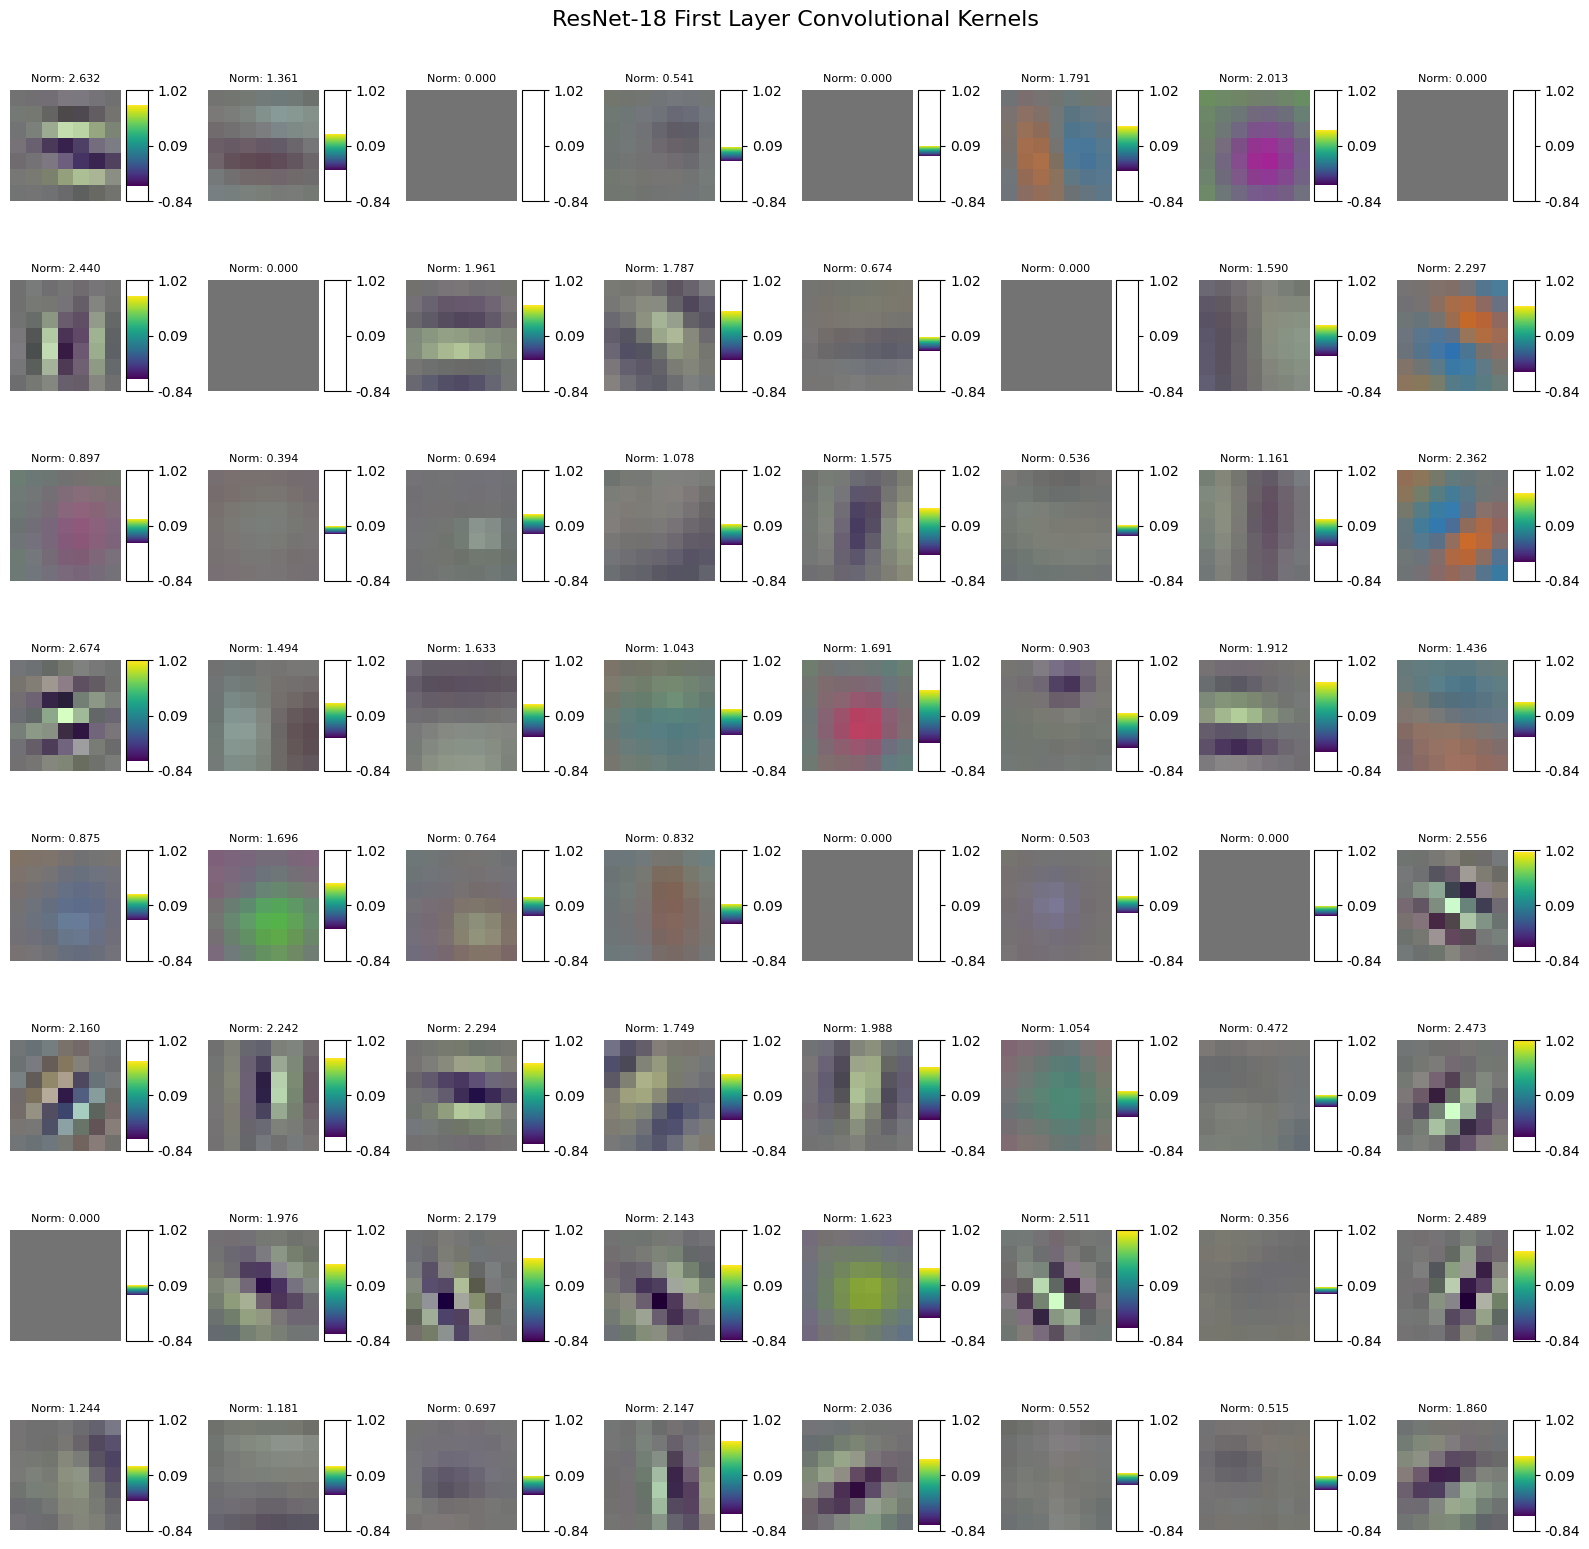

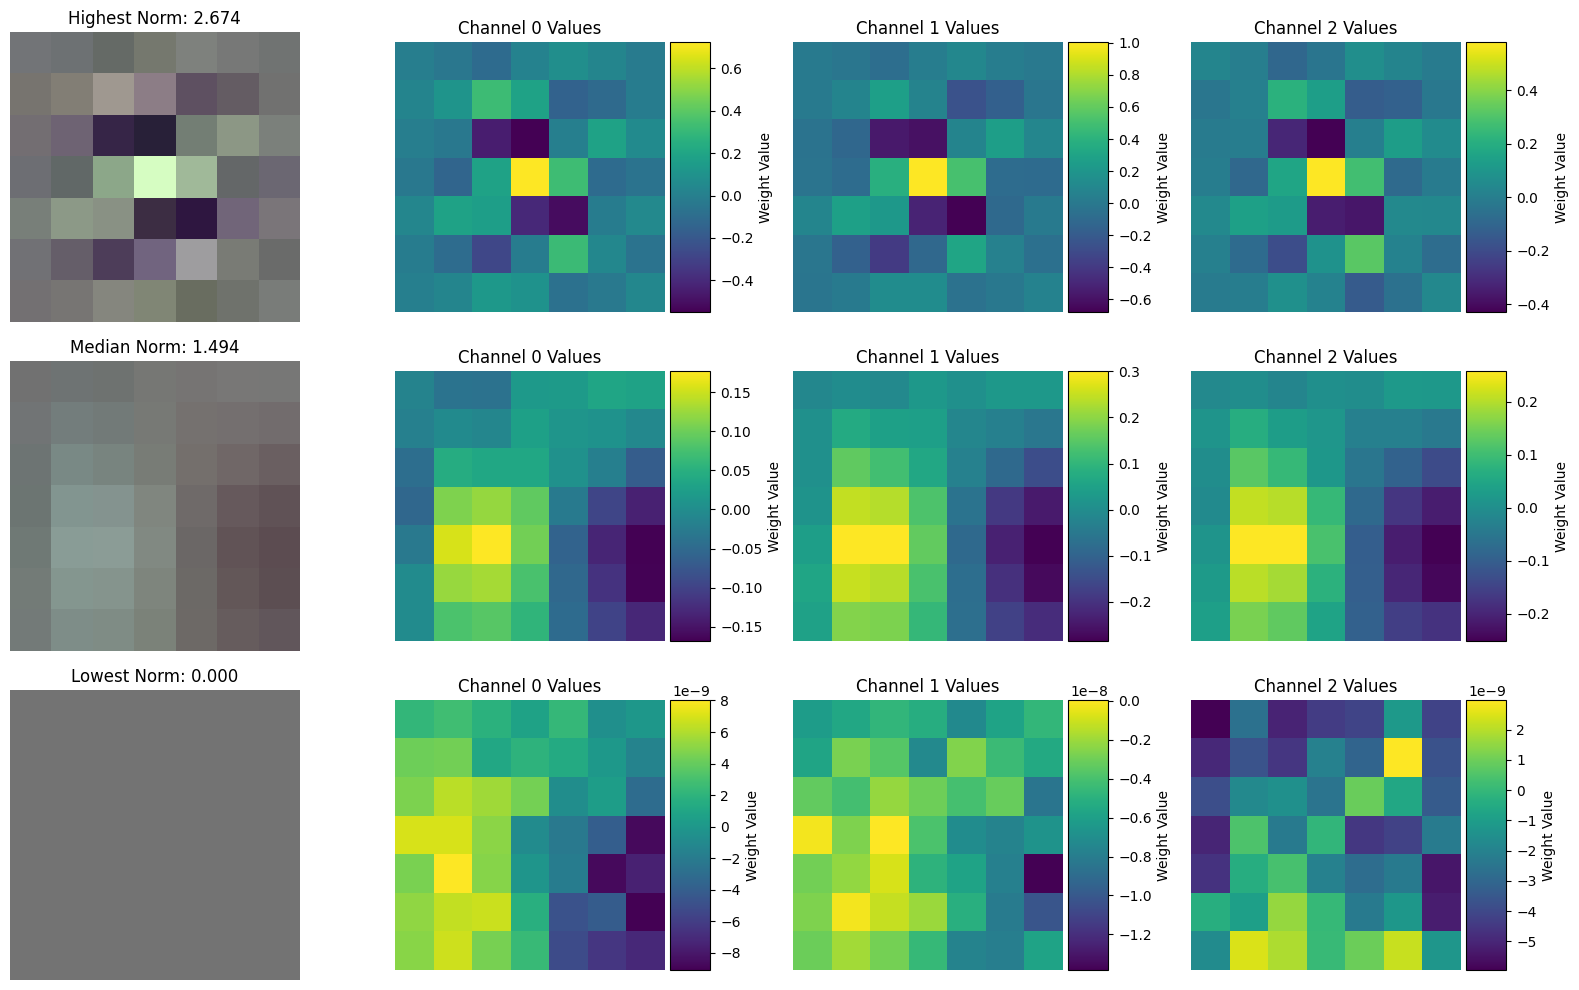

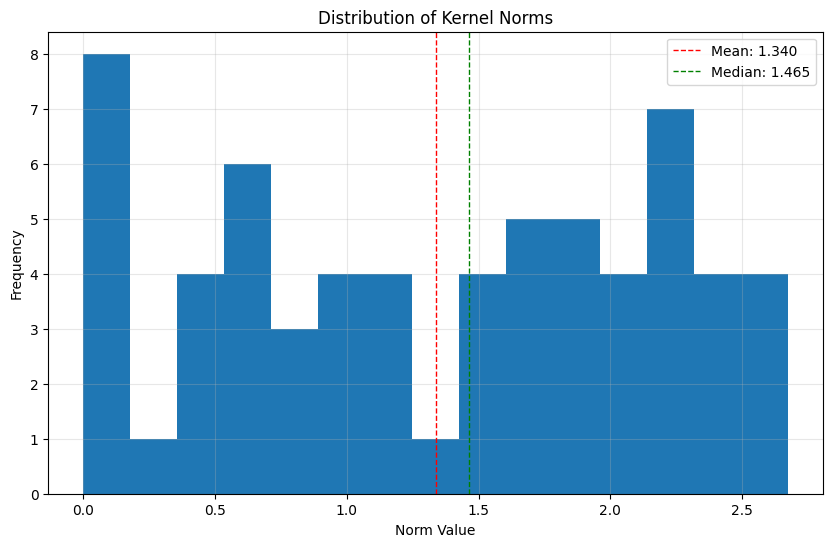

Number of kernels in first layer: 64
Kernel size: 7x7
Input channels: 3
Norm statistics:
  Min norm: 0.0000
  Max norm: 2.6742
  Mean norm: 1.3396
  Median norm: 1.4651


In [2]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Get the first convolutional layer's weights
first_conv_weights = resnet18.conv1.weight.data.cpu().numpy()

# Function to visualize kernels with values and norms
def visualize_kernels(kernels):
    # Number of kernels in the first layer
    num_kernels = kernels.shape[0]
    
    # Create a grid to display all kernels
    grid_size = int(np.ceil(np.sqrt(num_kernels)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
    
    # Normalize kernel values for better visualization
    min_val = kernels.min()
    max_val = kernels.max()
    kernels_normalized = (kernels - min_val) / (max_val - min_val)
    
    kernel_index = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if kernel_index < num_kernels:
                # Get the kernel
                kernel = kernels[kernel_index]
                kernel_norm = np.linalg.norm(kernel)
                kernel_rgb = np.transpose(kernels_normalized[kernel_index], (1, 2, 0))
                
                # Create main image
                im = axes[i, j].imshow(kernel_rgb)
                
                # Add colorbar with kernel values
                divider = make_axes_locatable(axes[i, j])
                cax = divider.append_axes("right", size="20%", pad=0.05)
                cbar = plt.colorbar(im, cax=cax)
                cbar.set_ticks([0, 0.5, 1])
                cbar.set_ticklabels([f"{min_val:.2f}", f"{(min_val+max_val)/2:.2f}", f"{max_val:.2f}"])
                
                # Set the norm as the title
                axes[i, j].set_title(f"Norm: {kernel_norm:.3f}", fontsize=8)
                axes[i, j].axis('off')
                kernel_index += 1
            else:
                axes[i, j].axis('off')
    
    plt.suptitle('ResNet-18 First Layer Convolutional Kernels', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # Visualize specific kernels with the highest and lowest norms
    norms = [np.linalg.norm(kernels[i]) for i in range(num_kernels)]
    highest_norm_idx = np.argmax(norms)
    lowest_norm_idx = np.argmin(norms)
    median_norm_idx = np.argsort(norms)[num_kernels//2]
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    
    special_kernels = {
        "Highest Norm": highest_norm_idx,
        "Median Norm": median_norm_idx,
        "Lowest Norm": lowest_norm_idx
    }
    
    for row, (name, idx) in enumerate(special_kernels.items()):
        kernel = kernels[idx]
        kernel_norm = np.linalg.norm(kernel)
        kernel_normalized = (kernel - min_val) / (max_val - min_val)
        
        # Show combined RGB
        kernel_rgb = np.transpose(kernel_normalized, (1, 2, 0))
        im0 = axes[row, 0].imshow(kernel_rgb)
        axes[row, 0].set_title(f"{name}: {kernel_norm:.3f}")
        
        # Show individual channels
        for c in range(3):
            im = axes[row, c+1].imshow(kernel[c], cmap='viridis')
            axes[row, c+1].set_title(f"Channel {c} Values")
            
            # Add colorbar with actual values
            divider = make_axes_locatable(axes[row, c+1])
            cax = divider.append_axes("right", size="15%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            cbar.set_label("Weight Value")
    
    for ax in axes.flat:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the visualization function
visualize_kernels(first_conv_weights)

# Calculate and display statistics about the kernel norms
norms = [np.linalg.norm(first_conv_weights[i]) for i in range(first_conv_weights.shape[0])]
plt.figure(figsize=(10, 6))
plt.hist(norms, bins=15)
plt.title('Distribution of Kernel Norms')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.axvline(np.mean(norms), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(norms):.3f}')
plt.axvline(np.median(norms), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(norms):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary information
print(f"Number of kernels in first layer: {first_conv_weights.shape[0]}")
print(f"Kernel size: {first_conv_weights.shape[2]}x{first_conv_weights.shape[3]}")
print(f"Input channels: {first_conv_weights.shape[1]}")
print(f"Norm statistics:")
print(f"  Min norm: {min(norms):.4f}")
print(f"  Max norm: {max(norms):.4f}")
print(f"  Mean norm: {np.mean(norms):.4f}")
print(f"  Median norm: {np.median(norms):.4f}")

In [6]:
import torch
import torchvision.models as models
import numpy as np
from collections import OrderedDict

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

# Function to calculate norms for each kernel in a convolutional layer
def calculate_kernel_norms(conv_layer):
    # Get the weights tensor
    weights = conv_layer.weight.data.cpu().numpy()
    
    # Calculate the L2 norm for each kernel
    norms = []
    for i in range(weights.shape[0]):  # iterate over output channels
        kernel = weights[i]
        norm = np.linalg.norm(kernel)
        norms.append(norm)
    
    return np.array(norms)

# Function to find all convolutional layers in the model
def get_all_conv_layers(model):
    conv_layers = OrderedDict()
    
    # Add the initial conv layer
    conv_layers['conv1'] = model.conv1
    
    # Add convolutional layers from each residual block
    for layer_name, layer in [
        ('layer1', model.layer1),
        ('layer2', model.layer2),
        ('layer3', model.layer3),
        ('layer4', model.layer4)
    ]:
        for block_idx, block in enumerate(layer):
            # Each BasicBlock has two conv layers
            conv_layers[f'{layer_name}.{block_idx}.conv1'] = block.conv1
            conv_layers[f'{layer_name}.{block_idx}.conv2'] = block.conv2
            
            # Check if there's a downsample conv layer
            if block.downsample is not None and isinstance(block.downsample[0], torch.nn.Conv2d):
                conv_layers[f'{layer_name}.{block_idx}.downsample.0'] = block.downsample[0]
    
    return conv_layers

# Get all convolutional layers
conv_layers = get_all_conv_layers(resnet18)

# Calculate and print statistics for each layer
print(f"{'Layer Name':<30} {'Min Norm':<12} {'Max Norm':<12} {'Mean Norm':<12} {'Median Norm':<12}")
print('-' * 80)

for name, layer in conv_layers.items():
    norms = calculate_kernel_norms(layer)
    
    # Calculate statistics
    min_norm = norms.min()
    max_norm = norms.max()
    mean_norm = norms.mean()
    median_norm = np.median(norms)
    
    # Print formatted statistics
    print(f"{name:<30} {min_norm:<12.4f} {max_norm:<12.4f} {mean_norm:<12.4f} {median_norm:<12.4f}")

# Print summary statistics across all convolutional layers
all_norms = []
for name, layer in conv_layers.items():
    norms = calculate_kernel_norms(layer)
    all_norms.extend(norms)

all_norms = np.array(all_norms)
print('\nOverall Statistics:')
print(f"Total number of convolutional kernels: {len(all_norms)}")
print(f"Global min norm: {all_norms.min():.4f}")
print(f"Global max norm: {all_norms.max():.4f}")
print(f"Global mean norm: {all_norms.mean():.4f}")
print(f"Global median norm: {np.median(all_norms):.4f}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Steven/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:12<00:00, 6.82MB/s]

Layer Name                     Min Norm     Max Norm     Mean Norm    Median Norm 
--------------------------------------------------------------------------------
conv1                          0.0000       2.6272       1.2415       1.3001      
layer1.0.conv1                 0.5226       1.6226       0.9897       0.9727      
layer1.0.conv2                 0.3706       1.2128       0.8141       0.8291      
layer1.1.conv1                 0.5844       1.2437       0.8823       0.8847      
layer1.1.conv2                 0.4102       1.1086       0.7939       0.7815      
layer1.2.conv1                 0.5452       1.1386       0.8577       0.8743      
layer1.2.conv2                 0.2468       1.0488       0.7453       0.7317      
layer2.0.conv1                 0.6053       1.0548       0.8403       0.8482      
layer2.0.conv2                 0.2077       1.4389       0.8885       0.9243      
layer2.0.downsample.0          0.1182       1.1833       0.5114       0.4421      
layer2